# Импортирование необходимых библиотек

In [1]:
from sentinelhub import SHConfig
from sentinelhub import SentinelHubCatalog

import datetime, os, csv, math
from math import ceil
import matplotlib.pyplot as plt
import numpy as np
from shapely.ops import unary_union
from fiona.drvsupport import supported_drivers
import geopandas as gpd
from matplotlib.path import Path
from shapely.geometry import Polygon
import earthpy.spatial as es
import earthpy.plot as ep
import numpy.ma as ma
from scipy.stats.mstats import gmean, hmean
import pandas as pd
import seaborn as sns
from functools import reduce

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
    filter_times
)

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import plot_image

colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange', 'blue',
          'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan']

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
sns.set()

# Подключение к аккаунту Sentinel Hub

In [3]:
CLIENT_ID = os.getenv('CLIENT_ID')
CLIENT_SECRET = os.environ.get('CLIENT_SECRET')

config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [4]:
catalog = SentinelHubCatalog(config=config)
# catalog.get_info()

# Получение координат экспериментального пастбища 

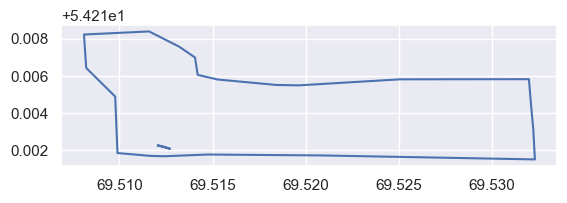

In [5]:
supported_drivers['KML'] = 'rw'
pasture_df = gpd.read_file('pasture.kml', driver='KML')

all_zagons = []
for zagon in range(len(pasture_df.index)):
    all_zagons.append(pasture_df.loc[zagon].geometry)
    
merged_zagons = unary_union(all_zagons)

gpd.GeoSeries([merged_zagons]).boundary.plot()
plt.show()

In [6]:
x_min, y_min, x_max, y_max = merged_zagons.bounds
pasture_coords_wgs84 = (x_min, y_min, x_max, y_max)

# Отправка запросов и получение снимков 

In [7]:
resolution = 10
pasture_bbox = BBox(bbox=pasture_coords_wgs84, crs=CRS.WGS84)
pasture_size = bbox_to_dimensions(pasture_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {pasture_size} pixels")

Image shape at 10 m resolution: (157, 78) pixels


# Доступные базы данных (Спутиковые базы!!!)

In [8]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL


# Выбор одной из доступных баз данных

In [9]:
data_collection = DataCollection.SENTINEL2_L1C
bands_dict = dict([(band.name, i) for i, band in enumerate(data_collection.bands)])
aux_data_dict = dict([(band, i) for i, band in enumerate(["sunZenithAngles","sunAzimuthAngles","viewZenithMean","viewAzimuthMean"])])

# Составление запросов

In [10]:
evalscript_all_bands = """
    //VERSION=3
    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DN"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in bands_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(bands_dict))}
evalscript_all_bands = evalscript_all_bands.format(**settings)

In [11]:
evalscript_aux_data = """
    //VERSION=3

    function setup() {{
        return {{
            input: [{{
                bands: [{BANDS}],
                units: "DEGREES"
            }}],
            output: {{
                bands: {COUNT},
                sampleType: "FLOAT32"
            }}
        }};
    }}

    function evaluatePixel(sample) {{
        return [{SAMPLE}];
    }}
"""
template1 = ""; template2 = ""
for band in aux_data_dict.keys(): 
    template1 += f'"{band}", '; 
    template2 += f'sample.{band}, ';
settings = {"BANDS": template1, "SAMPLE": template2, "COUNT": str(len(aux_data_dict))}
evalscript_aux_data = evalscript_aux_data.format(**settings)

# Снимки на даты (с 01.05.2022 по 31.08.2022)

In [12]:
time_interval = "2022-05-01", "2022-08-31"

search_iterator = catalog.search(
    data_collection,
    bbox=pasture_bbox,
    time=time_interval,
    filter="eo:cloud_cover <= 100",
    fields={"include": ["id", "properties.datetime", "properties.eo:cloud_cover"], "exclude": []},
)

results = list(search_iterator)
print("Total number of results:", len(results))

# results

Total number of results: 49


In [13]:
time_difference = datetime.timedelta(hours=1)

all_timestamps = search_iterator.get_timestamps()
unique_acquisitions = filter_times(all_timestamps, time_difference)

# unique_acquisitions

In [14]:
all_bands_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_all_bands,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    all_bands_process_requests.append(request)

In [15]:
aux_data_process_requests = []

for timestamp in unique_acquisitions:
    request = SentinelHubRequest(
        evalscript=evalscript_aux_data,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=data_collection,
                time_interval=(timestamp - time_difference, timestamp + time_difference),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        bbox=pasture_bbox,
        size=pasture_size,
        config=config,
    )
    aux_data_process_requests.append(request)

In [16]:
%%time

client = SentinelHubDownloadClient(config=config)
all_bands_download_requests = [request.download_list[0] for request in all_bands_process_requests]
all_bands_data = client.download(all_bands_download_requests)

Wall time: 7.45 s


In [17]:
%%time

client = SentinelHubDownloadClient(config=config)
aux_data_download_requests = [request.download_list[0] for request in aux_data_process_requests]
aux_data = client.download(aux_data_download_requests)

Wall time: 12.4 s


# Составление маски пастбища

In [18]:
 aoi_height, aoi_width, _ = all_bands_data[-1].shape

In [19]:
masks = []
pasture_edges = []
for zagon in range(len(pasture_df)-1):
    polygon=[]

    for coords in pasture_df.loc[zagon].geometry.exterior.coords:

        x = int(np.interp(coords[0], [x_min, x_max], [0, aoi_width]))
        y = int(np.interp(coords[1], [y_min, y_max], [aoi_height, 0]))

        polygon.append((y, x))
        
    poly_path=Path(polygon)
    x, y = np.mgrid[:aoi_height, :aoi_width]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    pasture_edges.append(Polygon(polygon))
    
    mask = ~poly_path.contains_points(coors)
    masks.append(mask)
    
combined_mask = reduce(np.logical_and, masks)

# Маска для загона №1 

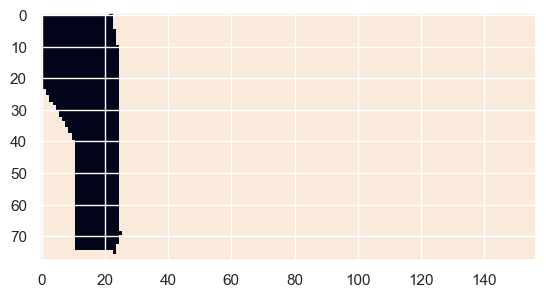

In [20]:
plt.imshow(masks[0].reshape(aoi_height, aoi_width))
plt.show()

# Маска для пастбища

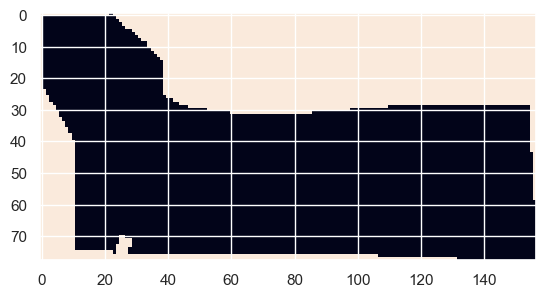

In [21]:
plt.imshow(combined_mask.reshape(aoi_height, aoi_width))
plt.show()

# Объявление вспомогательных функции

In [22]:
def normalize(band):
    band_min, band_max = (band.min(), band.max())
    return ((band - band_min)/((band_max - band_min)))

def brighten(band):
    alpha=0.13
    beta=0
    return np.clip(alpha*band+beta, 0, 255)

def Kcluster(matrix, n_clusters=3):
#     scaler = MinMaxScaler(); matrix = scaler.fit_transform(matrix);
#     scaler = StandardScaler(); matrix = scaler.fit_transform(matrix);

    flattened_matrix = matrix.flatten()

    kmeans = KMeans(n_clusters=n_clusters, random_state=45)
    kmeans.fit(flattened_matrix.reshape(-1, 1))

    cluster_labels = kmeans.labels_
    result_index = cluster_labels.reshape(matrix.shape)
    result_index = ma.masked_array(result_index, mask=combined_mask.reshape(aoi_height, aoi_width))

    return ~(result_index == 0), ~(result_index == 1), ~(result_index == 2) 

def get_only_pasture(index):
    only_pasture = ma.masked_array(ma.masked_array((index), mask=np.isinf((index)) | np.isnan((index))), mask=combined_mask.reshape(aoi_height, aoi_width))
    return only_pasture

def mean(index):
    return float(index.mean())

def median(index):
    return float(ma.median(index))


def show_real_pasture():
    
    fig, ax = plt.subplots(figsize=(12, 6))
    for zagon in range(len(pasture_df)-1):
        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])
    ep.plot_rgb(np.stack([RED, GREEN, BLUE]), ax=ax, title=general_info, figsize=(12, 6))
    plt.show()    

    
def show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=True, save_excel=False):
    
    fig, ax = plt.subplots(figsize=(12, 12))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    header = input_text
    precision = 4
    # print(f"Макс: {round(float(test_meet.max()),precision)} || Мин: {round(float(test_meet.min()),precision)} || Сред: {round(float(test_meet.mean()),precision)} || Сумм: {round(float(test_meet.sum()),precision)}")
    ep.plot_bands(test_meet, title=f"{header} {general_info}", ax=ax, cmap="bwr", cols=1, vmin=lower_bound, vmax=upper_bound, figsize=(10, 14))
    plt.show()

    test_index_masked_array = []
    for i, mask in enumerate(masks):
        mx = ma.masked_array(test_meet, mask=mask.reshape(aoi_height, aoi_width))
        test_index_masked_array.append(mx)

    summary_data = []
    for i, zagon in enumerate(test_index_masked_array):
        summary_data.append([f"№{i+1}", round(zagon.sum(),precision), round(zagon.mean(),precision), round(ma.median(zagon),precision), round(zagon.max(),precision), round(zagon.min(),precision)])


    styles = [
        {'selector': '',
         'props': [('border', '2px solid #000'), ('border-collapse', 'collapse')]},
        {'selector': 'th',
         'props': [('border', '2px solid #000')]},
        {'selector': 'td',
         'props': [('border', '1px solid #000'), ('padding', '5px')]}
    ]

    summary_df = pd.DataFrame(data = summary_data, columns=["Загон", "Сумма", "Cреднаяя", "Медианная", "Макс", "Мин"])
    sum_row = pd.DataFrame({'Загон': ["Пастбище"], 'Сумма': [summary_df['Сумма'].sum()], 'Cреднаяя': [round(float(test_meet.mean()),precision)], 'Медианная': [round(float(ma.median(test_meet)),precision)], 'Макс': [summary_df['Макс'].max()], 'Мин': [summary_df['Мин'].min()]}, index=[len(summary_df.index)])
    summary_df = pd.concat([summary_df, sum_row])
    if save_excel:
        summary_df.to_excel(f"Summary_{date_chosen}_{data_collection.processing_level}.xlsx", index=None)
    styled_df = summary_df.style.set_table_styles(styles)
    styled_df.hide(axis="index")
    
    display(styled_df)

    if show_hists:
        for i, zagon in enumerate(test_index_masked_array):
            ep.hist(zagon, colors = colors[i], title=f'{header} || Загон-{i+1} {general_info}', cols=4, alpha=0.5,
            figsize = (10, 6))    
            plt.axvline(test_index_masked_array[i].mean(), color='b', linestyle='dashed', linewidth=2)
            plt.axvline(ma.median(test_index_masked_array[i]), color='r', linestyle='dashed', linewidth=2)
            has_negative_or_zero = test_index_masked_array[i] <= 0
            if not has_negative_or_zero.sum():
                plt.axvline(hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='g', linestyle='dashed', linewidth=2)
                plt.axvline(gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height)), color='y', linestyle='dashed', linewidth=2)
                plt.legend([f"Средняя: {test_index_masked_array[i].mean()}",f"Медианная: {ma.median(test_index_masked_array[i])}",f"Гармоническая: {hmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}",f"Геометрическая: {gmean(test_index_masked_array[i].reshape(aoi_width * aoi_height))}"], title=f'Сумма: {round(zagon.sum(),precision)}')
            else:
                plt.legend([f"Средняя: {ma.mean(test_index_masked_array[i])}",f"Медианная: {ma.median(test_index_masked_array[i])}"], title=f'Сумма: {round(zagon.sum(),precision)}')
        plt.show()
        
        
def get_all_bands(by_pasture=True):
    global ULTRA_BLUE, BLUE, GREEN, RED, RED_EDGE1, RED_EDGE2, RED_EDGE3, NIR, N_NIR, WV, SWIR_C, SWIR2, SWIR3, SAA, SZA, VAM, VZM
    
    if by_pasture:
        # Нормализированные по пастбищу
        ULTRA_BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = normalize(brighten(get_only_pasture(all_bands_data[image_date][:, :, bands_dict["B12"]])))
    else:
        # НЕ Нормализированные по пастбищу
        ULTRA_BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B01"]])))

        BLUE = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B02"]])))
        GREEN = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B03"]])))
        RED = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B04"]])))

        RED_EDGE1 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B05"]])))
        RED_EDGE2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B06"]])))
        RED_EDGE3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B07"]])))

        NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B08"]])))
        N_NIR = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B8A"]])))
        WV = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B09"]])))
        if "B10" in bands_dict:
            SWIR_C = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B10"]])))
        SWIR2 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B11"]])))
        SWIR3 = get_only_pasture(normalize(brighten(all_bands_data[image_date][:, :, bands_dict["B12"]])))

    SAA = (aux_data[image_date][:, :, aux_data_dict["sunAzimuthAngles"]]).mean()
    SZA = (aux_data[image_date][:, :, aux_data_dict["sunZenithAngles"]]).mean()
    VAM = (aux_data[image_date][:, :, aux_data_dict["viewAzimuthMean"]]).mean()
    VZM = (aux_data[image_date][:, :, aux_data_dict["viewZenithMean"]]).mean()

# Выбор порога облачности

In [23]:
white_noise_threshold = 255 # Значение [0-255]  
white_noise_count = 12246 # Количество 157*78=[0-12246]

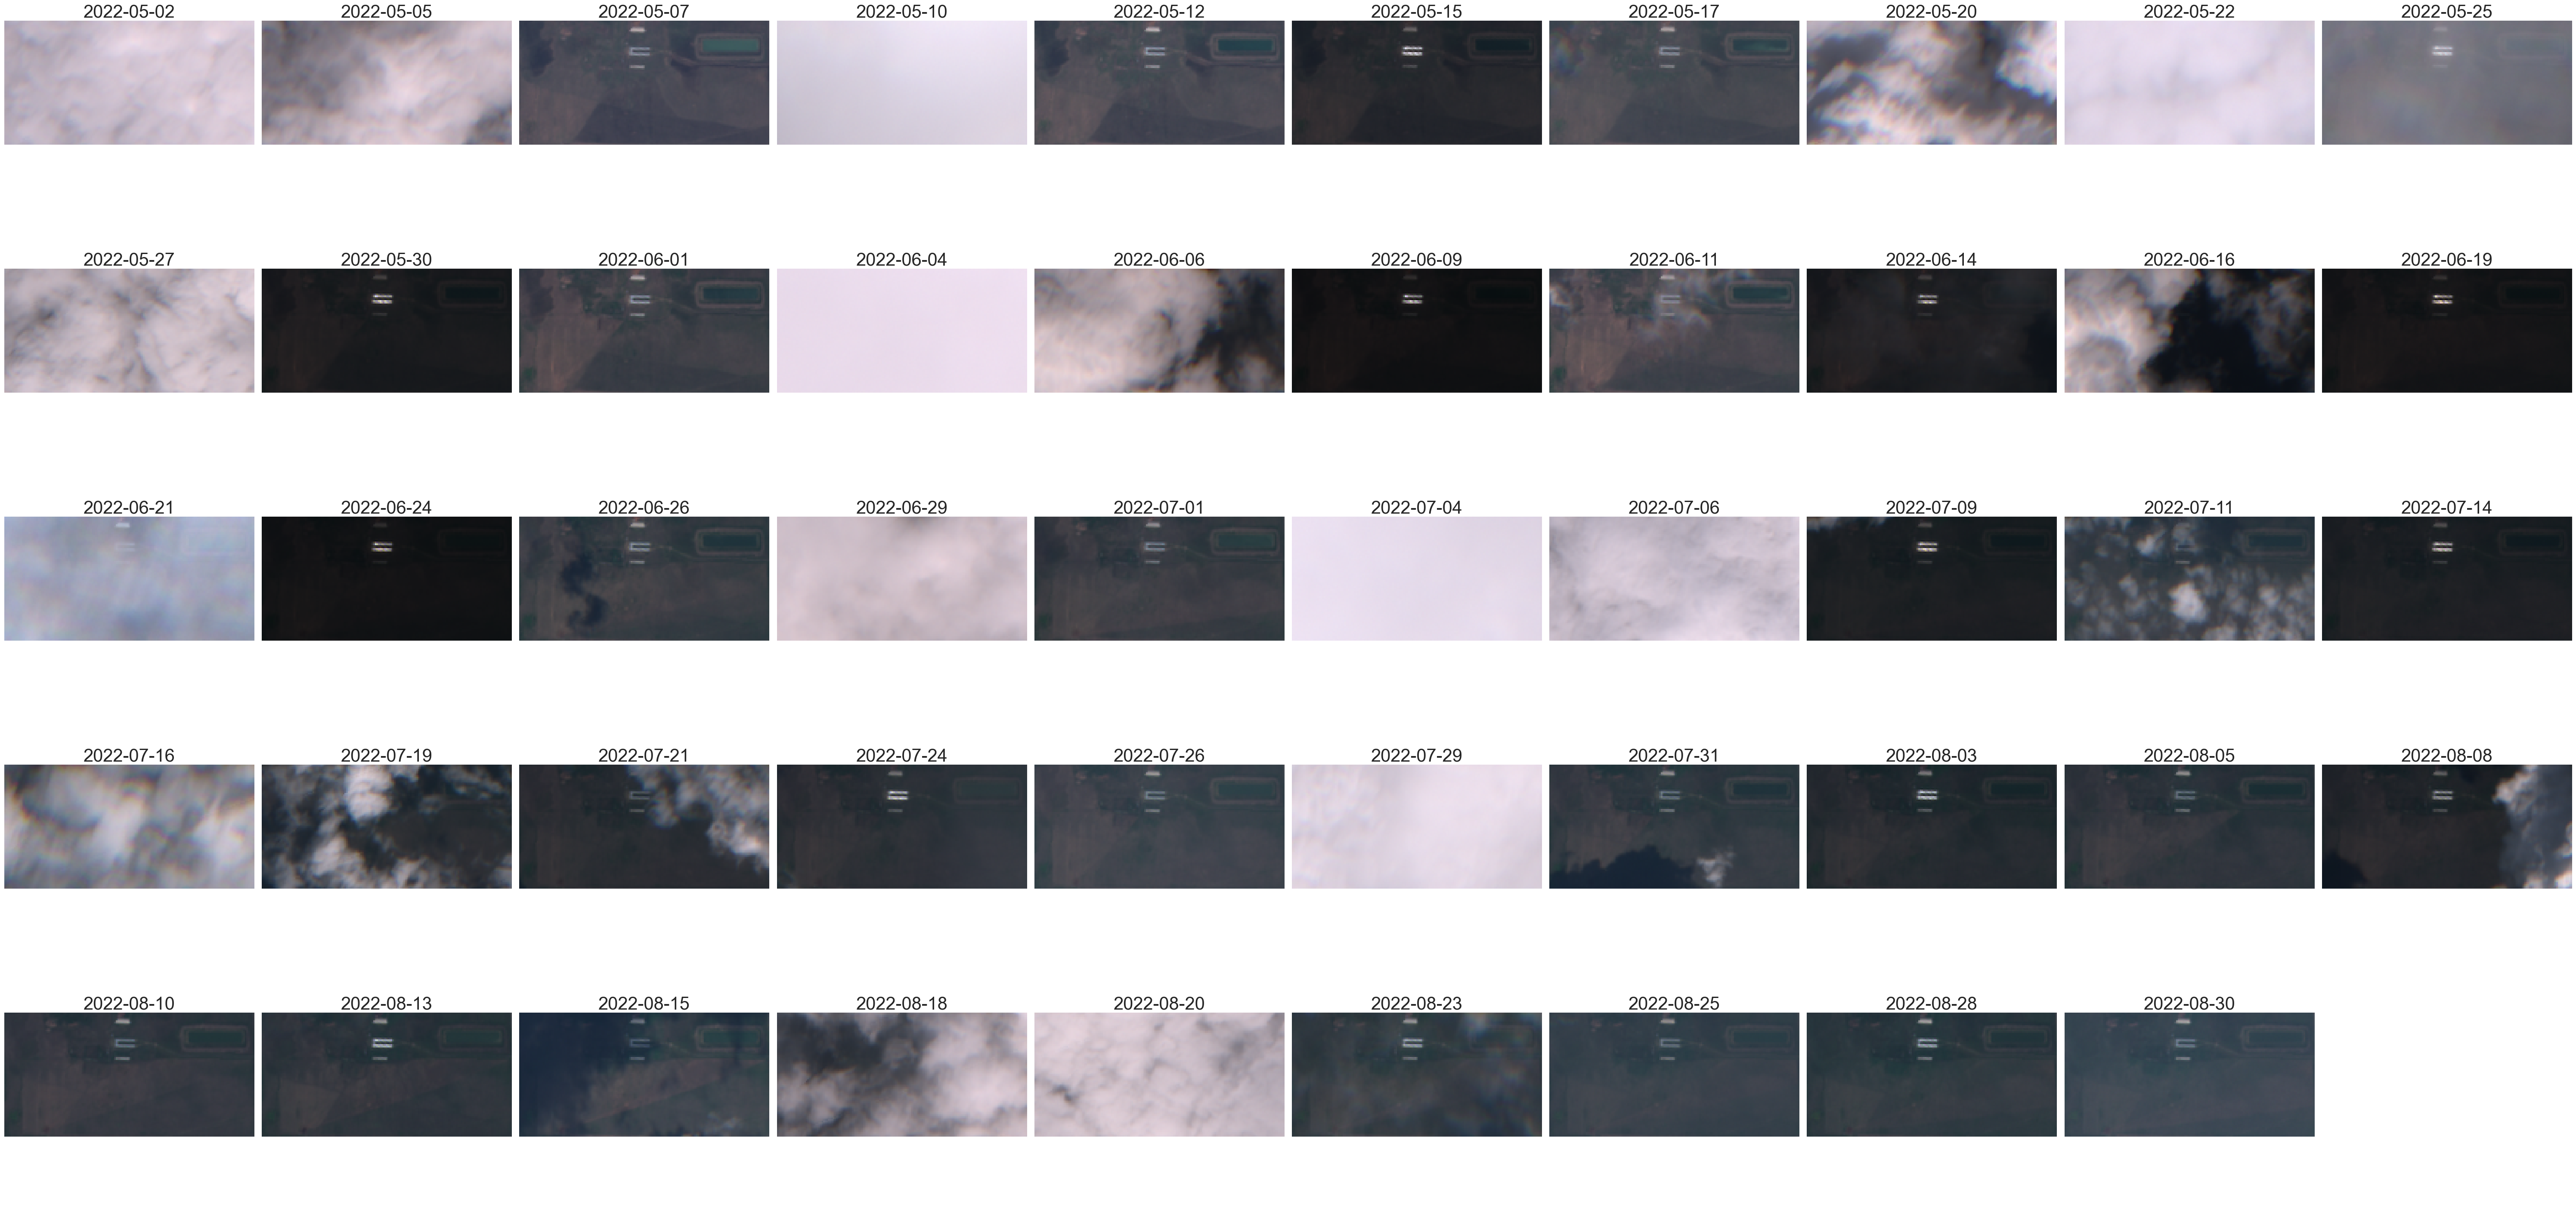

In [24]:
cols = 10
ncols, nrows = cols, ceil(len(results)/cols) 

fig, axis = plt.subplots(
    ncols=ncols, nrows=nrows, figsize=(60, 30), subplot_kw={"xticks": [], "yticks": [], "frame_on": False}
)

idx = 0
clear_date_dict = []
for i, (image, timestamp) in enumerate(zip(all_bands_data, unique_acquisitions)):

    data = image.astype(np.float64) / image.max()
    data = 255 * data
    image = data.astype(np.uint8)
    
    mx1 = ma.masked_array(image[:,:,bands_dict["B02"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx2 = ma.masked_array(image[:,:,bands_dict["B03"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    mx3 = ma.masked_array(image[:,:,bands_dict["B04"]], mask=combined_mask.reshape(aoi_height, aoi_width))
    comb = mx1&mx2&mx3
    white_image = comb >= white_noise_threshold
    if white_image.sum() <= white_noise_count:
        clear_date_dict.append((str(timestamp.date().isoformat()), i))
        ax = axis[idx // ncols][idx % ncols]
        image = np.stack([image[:,:,bands_dict["B04"]], image[:,:,bands_dict["B03"]], image[:,:,bands_dict["B02"]]])
        ax.imshow(np.transpose(image, (1, 2, 0)))
        ax.set_title(timestamp.date().isoformat(), fontsize=30)
        idx += 1
        
clear_date_dict = dict(clear_date_dict)
plt.tight_layout()

# Выбор доступной даты 

In [62]:
date_chosen = "2022-07-14"
image_date = clear_date_dict[date_chosen]

get_all_bands()

precision = 4
general_info = f"|| {date_chosen} || SZA: {str(round(SZA, precision))}, VZA: {str(round(VZM, precision))} || Level: {data_collection.processing_level}"

# Исследование нового индекса

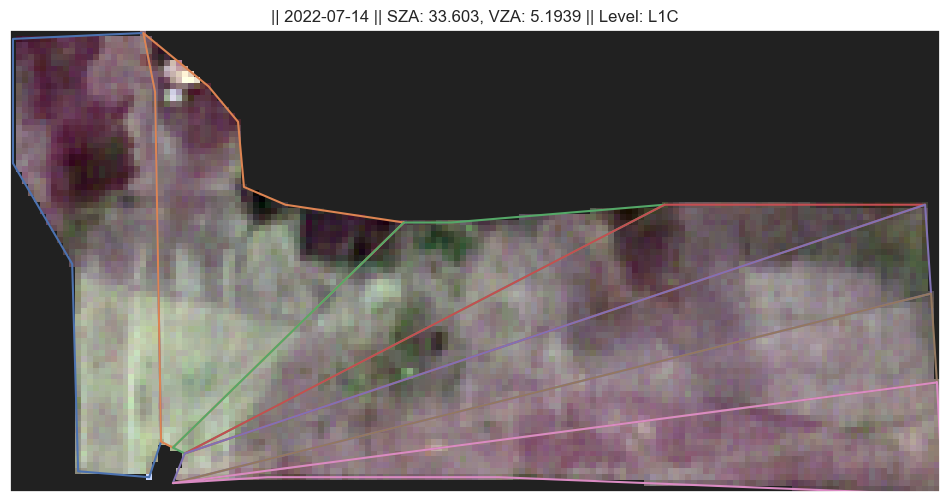

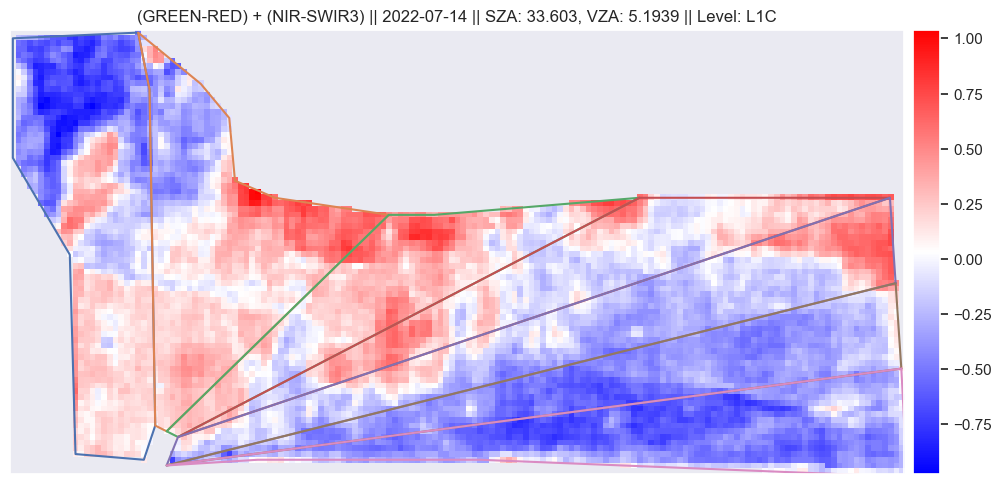

Загон,Сумма,Cреднаяя,Медианная,Макс,Мин
№1,-220.340195,-0.165300,-0.127400,0.620200,-0.976200
№2,171.818695,0.137500,0.172500,1.039300,-0.664700
№3,214.613907,0.250700,0.251600,0.885300,-0.305800
№4,93.521004,0.098700,0.065500,0.765100,-0.326600
№5,-68.641998,-0.054300,-0.143300,0.763700,-0.718300
№6,-370.351990,-0.373000,-0.389400,0.484000,-0.745500
№7,-476.442993,-0.426900,-0.445300,0.362800,-0.808400
Пастбище,-655.823608,-0.084100,-0.106500,1.039300,-0.976200


In [63]:
input_text = "(GREEN-RED) + (NIR-SWIR3)"
test_index = eval(input_text)

test_thresh = test_index.min() 
# test_thresh = (test_index.max() + test_index.min())/2

test_filter = test_index >= test_thresh; test_mask = ~test_filter
test_meet = ma.masked_array(test_index, mask=test_mask)

# lower_bound = -1;  upper_bound = 1
lower_bound = test_meet.min(); upper_bound = test_meet.max()

show_real_pasture()
show_pasture_index(test_meet, lower_bound, upper_bound, show_hists=False, save_excel=False)

# Разбивка на кластеры

In [44]:
# n_clusters = 3
# for cluster_mask in Kcluster(test_meet, n_clusters):
#     cluster = ma.masked_array(test_meet, mask=cluster_mask.reshape(aoi_height, aoi_width))
#     fig, ax = plt.subplots(figsize=(12, 12))
#     for zagon in range(len(pasture_df)-1):

#         ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

#     ep.plot_bands(cluster_mask, title=f"Кластер значении [{round(float(cluster.min()),precision)} - {round(float(cluster.max()),precision)}] канала {input_text} {general_info}", ax=ax, figsize=(10, 14))
# plt.show()

# Вывод всех каналов по отдельности

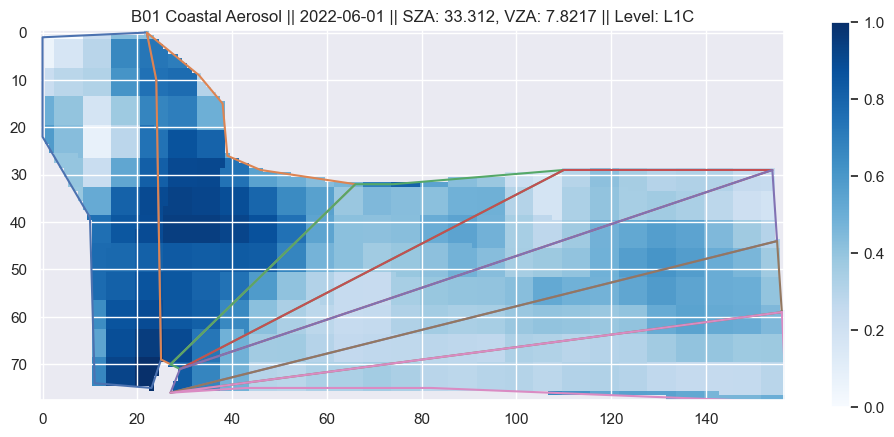

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(ULTRA_BLUE, cmap="Blues", vmin=ULTRA_BLUE.min(), vmax=ULTRA_BLUE.max())
plt.title(f"B01 Coastal Aerosol {general_info}")
plt.colorbar()
plt.show()

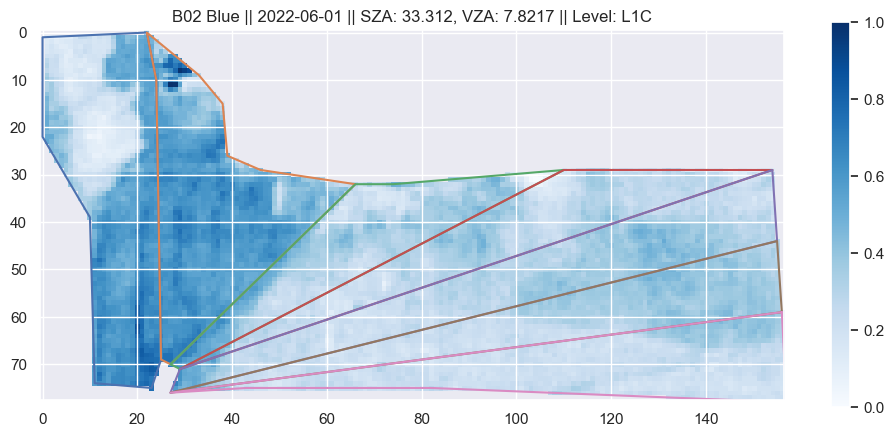

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(BLUE, cmap="Blues", vmin=BLUE.min(), vmax=BLUE.max())
plt.title(f"B02 Blue {general_info}")
plt.colorbar()
plt.show()

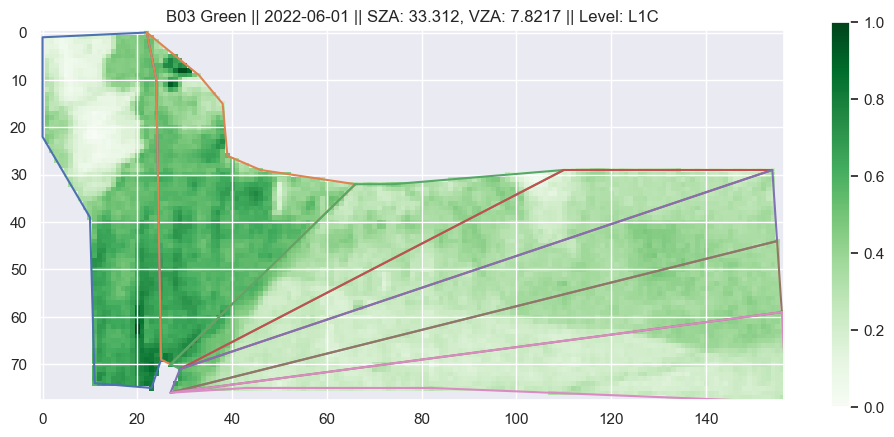

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(GREEN, cmap="Greens", vmin=GREEN.min(), vmax=GREEN.max())
plt.title(f"B03 Green {general_info}")
plt.colorbar()
plt.show()

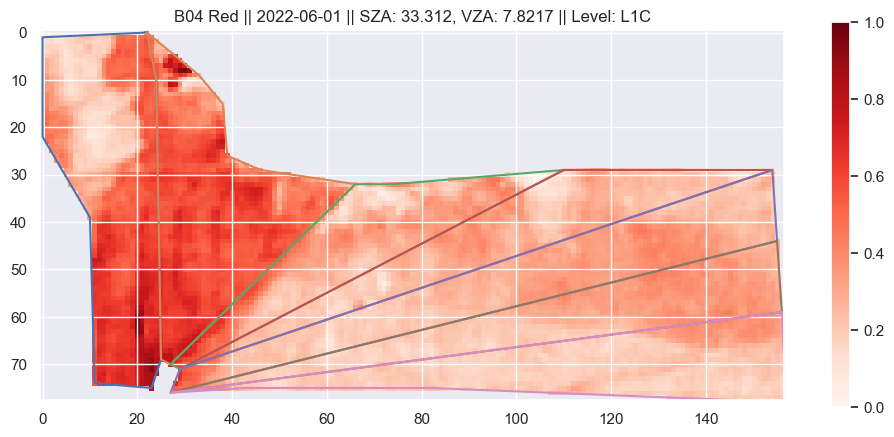

In [48]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED, cmap="Reds", vmin=RED.min(), vmax=RED.max())
plt.title(f"B04 Red {general_info}")
plt.colorbar()
plt.show()

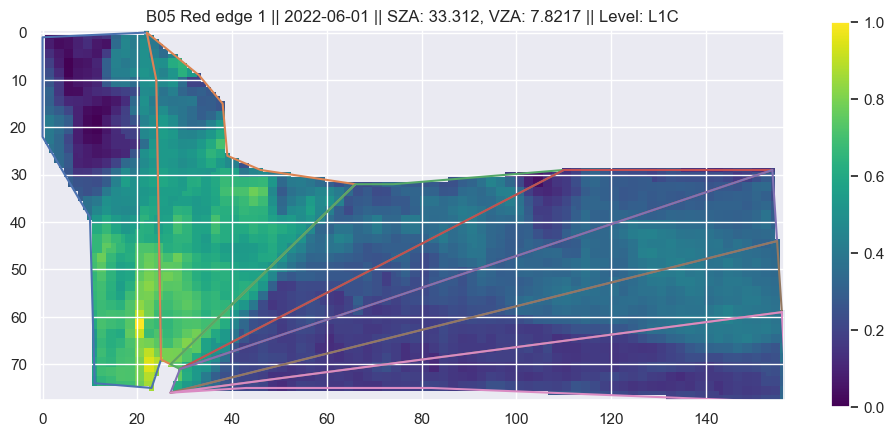

In [49]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE1, cmap="viridis", vmin=RED_EDGE1.min(), vmax=RED_EDGE1.max())
plt.title(f"B05 Red edge 1 {general_info}")
plt.colorbar()
plt.show()

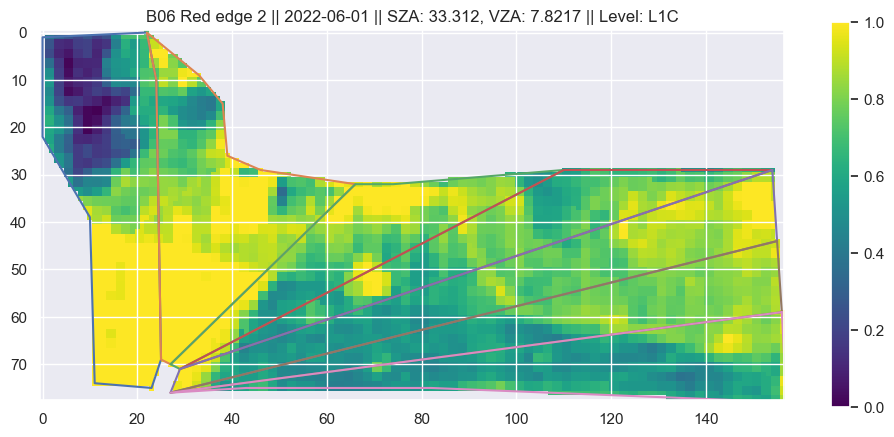

In [50]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE2, cmap="viridis", vmin=RED_EDGE2.min(), vmax=RED_EDGE2.max())
plt.title(f"B06 Red edge 2 {general_info}")
plt.colorbar()
plt.show()

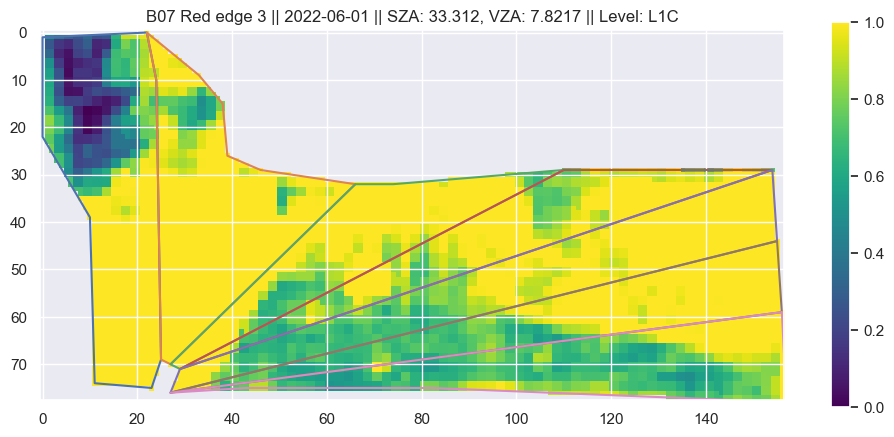

In [51]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(RED_EDGE3, cmap="viridis", vmin=RED_EDGE3.min(), vmax=RED_EDGE3.max())
plt.title(f"B07 Red edge 3 {general_info}")
plt.colorbar()
plt.show()

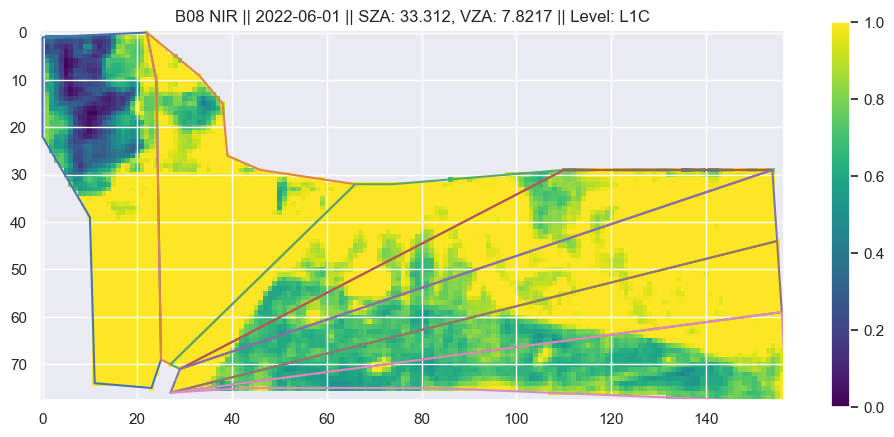

In [52]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(NIR, cmap="viridis", vmin=NIR.min(), vmax=NIR.max())
plt.title(f"B08 NIR {general_info}")
plt.colorbar()
plt.show()

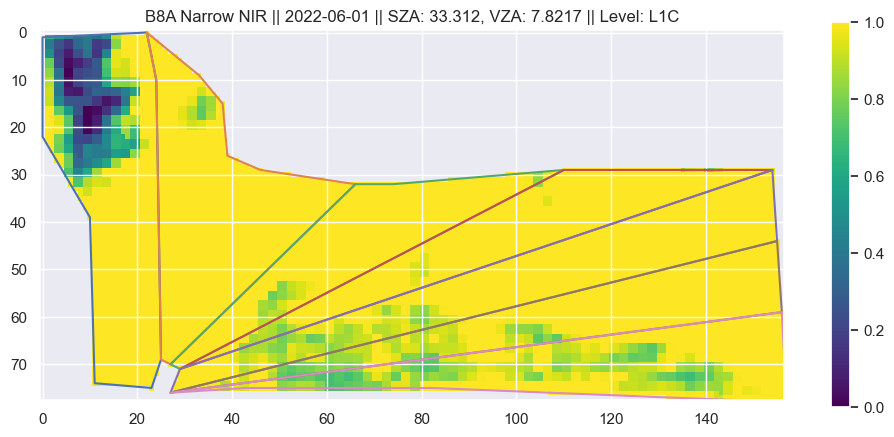

In [53]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(N_NIR, cmap="viridis", vmin=N_NIR.min(), vmax=N_NIR.max())
plt.title(f"B8A Narrow NIR {general_info}")
plt.colorbar()
plt.show()

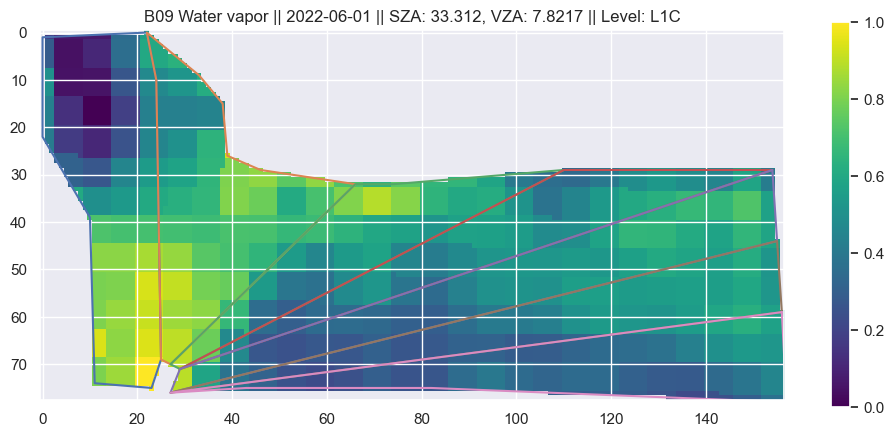

In [54]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(WV, cmap="viridis", vmin=WV.min(), vmax=WV.max())
plt.title(f"B09 Water vapor {general_info}")
plt.colorbar()
plt.show()

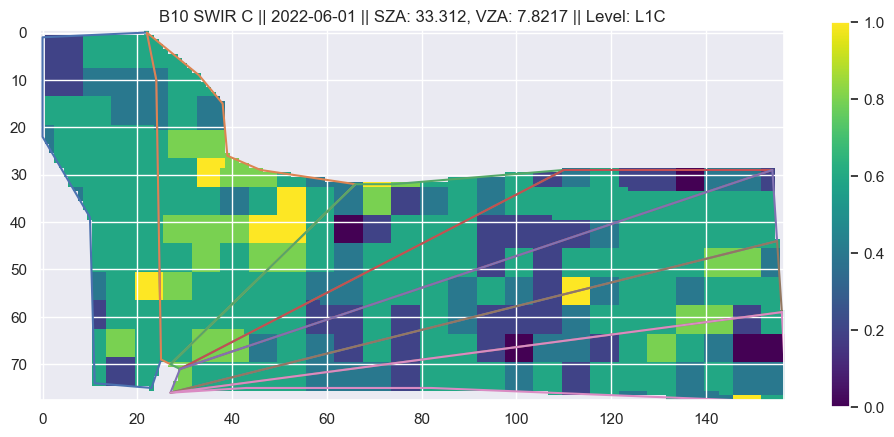

In [55]:
if "B10" in bands_dict:
    fig, ax = plt.subplots(figsize=(12, 5))
    for zagon in range(len(pasture_df)-1):

        ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

    plt.imshow(SWIR_C, cmap="viridis", vmin=SWIR_C.min(), vmax=SWIR_C.max())
    plt.title(f"B10 SWIR C {general_info}")
    plt.colorbar()
    plt.show()

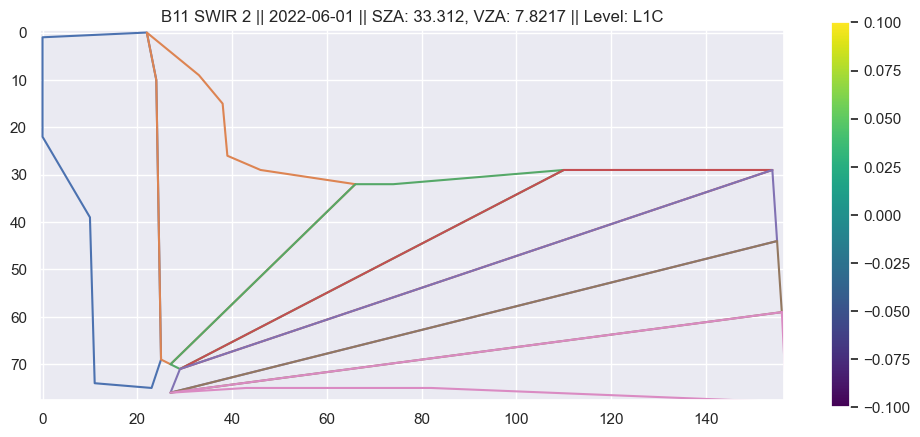

In [56]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR2, cmap="viridis", vmin=SWIR2.min(), vmax=SWIR2.max())
plt.title(f"B11 SWIR 2 {general_info}")
plt.colorbar()
plt.show()

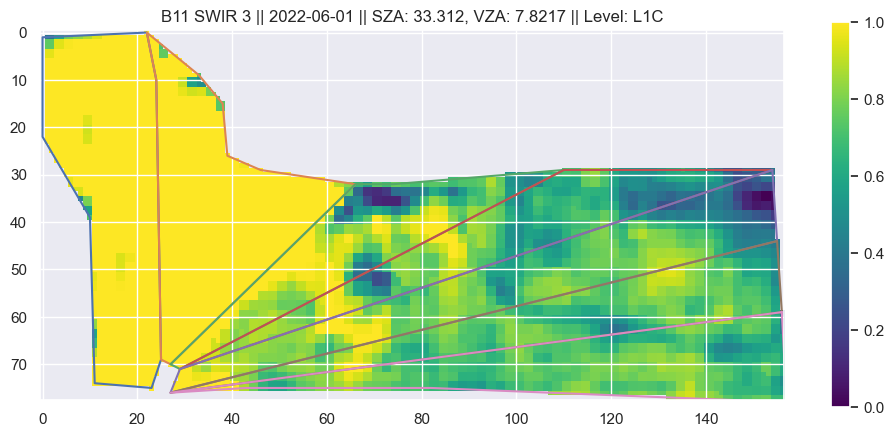

In [57]:
fig, ax = plt.subplots(figsize=(12, 5))
for zagon in range(len(pasture_df)-1):

    ax.plot(pasture_edges[zagon].exterior.xy[1], pasture_edges[zagon].exterior.xy[0])

plt.imshow(SWIR3, cmap="viridis", vmin=SWIR3.min(), vmax=SWIR3.max())
plt.title(f"B11 SWIR 3 {general_info}")
plt.colorbar()
plt.show()